## Poisonous Mushroom Pipeline

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [2]:
#import dataset
dataset = pd.read_csv('../raw_data/secondary_data.csv', sep=";", low_memory=False)

In [3]:
df = dataset.copy()

In [4]:
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [5]:
drop_columns = ['gill-spacing', 'stem-root', 
                'stem-surface', 'veil-type', 
                'veil-color', 'spore-print-color',
                'cap-surface']
df.drop(columns=drop_columns, inplace=True)

In [6]:
gender = {'p': 1,'e': 0}

df['class'] = [gender[item] for item in df['class']]

In [7]:
X = df.drop(columns='class')
y = df['class']

In [8]:
X.dtypes

cap-diameter            float64
cap-shape                object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object

In [9]:
preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(), make_column_selector(dtype_include="float64")),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include="object"))
])

preprocessor


ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1288d6b80>),
                                ('cat_encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1288d6c40>)])

In [10]:
pd.DataFrame(preprocessor.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.240155,0.499705,0.164469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.261782,0.530366,0.175055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.220949,0.524764,0.170725,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.222563,0.464917,0.153787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.230148,0.487323,0.165528,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
params = {
    "n_estimators": [1000],
    "max_depth": [30],
    "criterion": ["gini"]
}

In [12]:
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=1000,
                                                      criterion='gini', 
                                                      max_depth= 30,
                                                      random_state=123))
])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1288d6b80>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1288d6c40>)])),
                ('RandomForestClassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=1000,
                                        random_state=123))])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [14]:
X_train.head()

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
19898,5.07,b,e,f,e,g,5.22,7.08,k,f,f,g,u
47397,3.25,b,k,f,a,k,9.27,2.72,g,f,f,g,a
24235,6.84,x,e,f,x,w,6.24,11.93,w,f,f,d,a
32441,4.33,f,n,f,x,p,7.10,4.99,n,f,f,d,a
53453,12.07,x,r,t,d,n,5.50,14.65,n,f,f,h,a


In [15]:
fitted_pipe = pipe.fit(X_train, y_train)

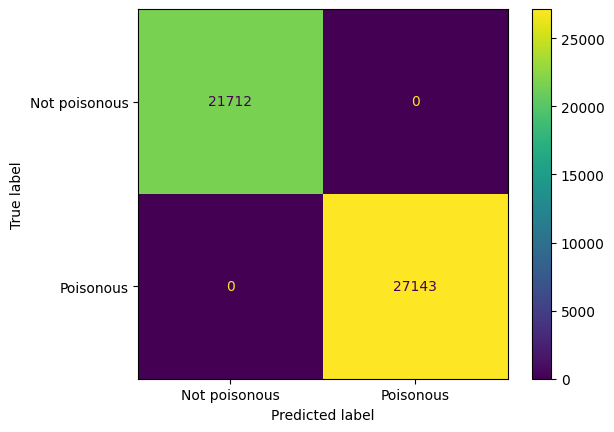

In [16]:
ConfusionMatrixDisplay.from_estimator(fitted_pipe, X_train, y_train, display_labels=["Not poisonous", "Poisonous"]);

In [17]:
acc_test = fitted_pipe.score(X_test, y_test)
print('accuracy:',round(acc_test,2)*100,'%')

accuracy: 100.0 %


In [20]:
from sklearn.metrics import classification_report

print("Random Forest classification report:")
print(classification_report(y_test, fitted_pipe.predict(X_test)))


Random Forest classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5469
           1       1.00      1.00      1.00      6745

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



In [21]:
predicted_test = fitted_pipe.predict(X_test)
matrix_test = confusion_matrix(y_test, predicted_test)

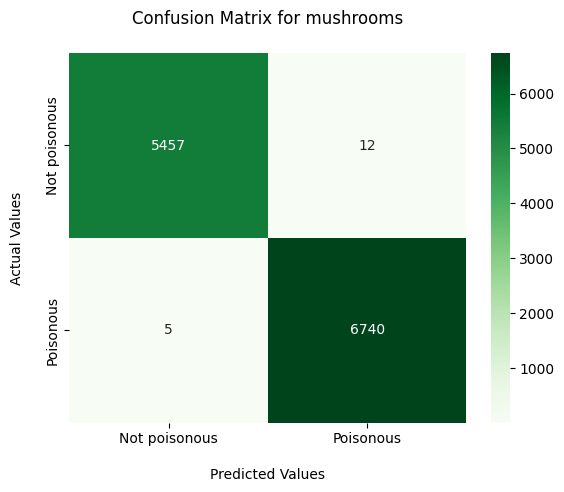

In [23]:
ax = sns.heatmap(matrix_test, annot=True, cmap="Greens", fmt="g")

ax.set_title("Confusion Matrix for mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()